# Simplest single-slit download and pipeline run

In [1]:
import os
from pathlib import Path
import json
import re
from copy import deepcopy

import numpy as np

from astroquery.mast import Observations

from astropy.io import fits
from astropy import table

from jwst import datamodels
from jwst.pipeline import Spec2Pipeline

%matplotlib inline
from matplotlib import pyplot as plt

Observations.login(os.environ['MAST_TOKEN'])

dl_path = Path('mastDownload/')

2024-02-22 19:46:49,886 - stpipe - INFO - MAST API token accepted, welcome Erik Tollerud


INFO: MAST API token accepted, welcome Erik Tollerud [astroquery.mast.auth]


In [2]:
obses = Observations.query_criteria(proposal_id=2609)
obses

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str12,str8,str27,str23,str40,float64,float64,str8,str14,int64,float64,float64,float64,float64,float64,str60,float64,str4,str2,int64,str115,str66,str67,str16,bool,float64,str9,str9
science,JWST,CALJWST,NIRSPEC/MSA,JWST,F110W;MIRROR,Infrared,NGC6791-NEWCATALOG-GAIAEDR3,--,jw02609008001_02101_00002_nrs1,290.21948,37.76622777777778,image,"Nidever, David",2,59811.67119774213,59811.67169481482,32.21,1000.0,1300.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,59968.616192,2609,GO,--,POLYGON 290.246308674 37.799969045 290.170557371 37.802988286 290.173976128 37.862571721 290.249813433 37.858268436,mast:JWST/product/jw02609008001_02101_00002_nrs1_cal.jpg,mast:JWST/product/jw02609008001_02101_00002_nrs1_cal.fits,PUBLIC,False,nan,89376201,391056271
science,JWST,CALJWST,NIRSPEC/MSA,JWST,F110W;MIRROR,Infrared,NGC6791-NEWCATALOG-GAIAEDR3,--,jw02609008001_02101_00002_nrs2,290.21948,37.76622777777778,image,"Nidever, David",2,59811.67119774213,59811.67169481482,32.21,1000.0,1300.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,59968.616192,2609,GO,--,POLYGON 290.241878974 37.737592338 290.16595988 37.739195427 290.170290683 37.798765269 290.246045144 37.795847808,mast:JWST/product/jw02609008001_02101_00002_nrs2_cal.jpg,mast:JWST/product/jw02609008001_02101_00002_nrs2_cal.fits,PUBLIC,False,nan,89376203,391056276
science,JWST,CALJWST,NIRSPEC/MSA,JWST,F110W;MIRROR,Infrared,NGC6791-NEWCATALOG-GAIAEDR3,--,jw02609008001_02101_00001_nrs1,290.21948,37.76622777777778,image,"Nidever, David",2,59811.66659922361,59811.667096296296,32.21,1000.0,1300.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,59968.616192,2609,GO,--,POLYGON 290.246403251 37.800002027 290.170651948 37.803021804 290.174071382 37.862605215 290.249908673 37.858301394,mast:JWST/product/jw02609008001_02101_00001_nrs1_cal.jpg,mast:JWST/product/jw02609008001_02101_00001_nrs1_cal.fits,PUBLIC,False,nan,89376205,391056290
science,JWST,CALJWST,NIRSPEC/MSA,JWST,F110W;MIRROR,Infrared,NGC6791-NEWCATALOG-GAIAEDR3,--,jw02609008001_02101_00001_nrs2,290.21948,37.76622777777778,image,"Nidever, David",2,59811.66659922361,59811.667096296296,32.21,1000.0,1300.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,59968.616192,2609,GO,--,POLYGON 290.241972844 37.737625352 290.166053733 37.739228977 290.170385212 37.798798789 290.246139675 37.795880793,mast:JWST/product/jw02609008001_02101_00001_nrs2_cal.jpg,mast:JWST/product/jw02609008001_02101_00001_nrs2_cal.fits,PUBLIC,False,nan,89376208,391056298
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F277W,Infrared,M31-NIRCAM-PREIMAGING,Galaxy; Spiral galaxies,jw02609-o001_t006_nircam_clear-f277w,11.5375,42.08777777777778,image,"Nidever, David",3,59810.65694376852,59810.677058009256,579.7860000000001,2416.0,3127.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,60178.64913193,2609,GO,--,POLYGON 11.625512875 42.084228042 11.550946577 42.027425799 11.455668682 42.096235438 11.530230532 42.15309936,mast:JWST/product/jw02609-o001_t006_nircam_clear-f277w_i2d.jpg,mast:JWST/product/jw02609-o001_t006_nircam_clear-f277w_i2d.fits,PUBLIC,False,nan,89383611,390528709
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W,Infrared,M31-NIRCAM-PREIMAGING,Galaxy; Spiral galaxies,jw02609-o001_t006_nircam_clear-f150w,11.5375,42.08777777777778,image,"Nidever, David",3,59810.65694302778,59810.677058009256,579.7860000000001,1331.0,1668.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,60178.64913193,2609,GO,--,POLYGON 11.626294139 42.085182162 11.551206833 42.026993085 11.454809877 42.095425524 11.529889742 42.15367744,mast:JWST/product/jw02609-o001_t006_nir

In [3]:
ims3 = obses[(obses['calib_level']==3) & (obses['dataproduct_type'] == 'image')]

In [4]:
specs3 = obses[(obses['calib_level']==3) & (obses['dataproduct_type'] != 'image')]

d = {}
for row in specs3:
    d.setdefault(row['target_name'], 0)
    d[row['target_name']] += 1
d

{'IC166-NEWCATALOG-GAIAEDR3': 58,
 'M31-FINAL-MSATA+TARGETS': 103,
 'M71-NEWCATALOG-GAIAEDR3': 74,
 'NGC6791-NEWCATALOG-GAIAEDR3': 69}

So those must be the actual spectra, good!

In [5]:
re.match('jw.*_(s.*?)_.*', 'jw02609-o007_s01035_nirspec_f100lp-g140h	28.09702').group(1)

's01035'

In [6]:
def filter_on_specname(name, table, target_name=None):
    msk = []
    for row in table:
        m = re.match('jw.*_(s.*?)_.*', row['obs_id'])
        match = m and m.group(1) == name
        if target_name is not None:
            match = match and (row['target_name']==target_name)
        msk.append(match)
    return table[np.array(msk)]

example_spec_tab = filter_on_specname('s01035', specs3, target_name='IC166-NEWCATALOG-GAIAEDR3')
example_spec_tab

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str12,str8,str27,str23,str40,float64,float64,str8,str14,int64,float64,float64,float64,float64,float64,str60,float64,str4,str2,int64,str115,str66,str67,str16,bool,float64,str9,str9
science,JWST,CALJWST,NIRSPEC/MSA,JWST,F100LP;G140H,Infrared,IC166-NEWCATALOG-GAIAEDR3,--,jw02609-o007_s01035_nirspec_f100lp-g140h,28.09702,61.86512777777778,spectrum,"Nidever, David",3,59891.81792711713,59891.855679699074,291.778,810.0,5000.0,Searching for the Alpha-Abundance Bimodality in the M31 Disk,60256.96119201,2609,GO,--,POLYGON 28.074579882 61.877969446 28.075552087 61.877969446 28.075552087 61.877667174 28.074579882 61.877667174,mast:JWST/product/jw02609-o007_s01035_nirspec_f100lp-g140h_cal.jpg,mast:JWST/product/jw02609-o007_s01035_nirspec_f100lp-g140h_s2d.fits,PUBLIC,False,nan,100544641,390754414


# Try drilling straight into a *single* target

In [7]:
ex_prods = Observations.get_product_list(example_spec_tab)
ex_prods

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str6,int64
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,source/target (L3) : association generator,D,mast:JWST/product/jw02609-o007_20240212t021359_spec3_00001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.12.5,2609,jw02609-o007_20240212t021359_spec3_00001_asn.json,5091,100544641,PUBLIC,3
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,source/target (L3) : association pool,D,mast:JWST/product/jw02609_20240212t021359_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.12.5,2609,jw02609_20240212t021359_pool.csv,76723,100544641,PUBLIC,3
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o007_s01035_nirspec_f100lp-g140h_cal.jpg,PREVIEW,--,--,--,CALJWST,1.12.5,2609,jw02609-o007_s01035_nirspec_f100lp-g140h_cal.jpg,590,100544641,PUBLIC,3
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o007_s01035_nirspec_f100lp-g140h_crf.jpg,PREVIEW,--,--,--,CALJWST,1.12.5,2609,jw02609-o007_s01035_nirspec_f100lp-g140h_crf.jpg,590,100544641,PUBLIC,3
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o007_s01035_nirspec_f100lp-g140h_s2d.jpg,PREVIEW,--,--,--,CALJWST,1.12.5,2609,jw02609-o007_s01035_nirspec_f100lp-g140h_s2d.jpg,10809,100544641,PUBLIC,3
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o007_s01035_nirspec_f100lp-g140h_x1d.png,PREVIEW,--,--,--,CALJWST,1.12.5,2609,jw02609-o007_s01035_nirspec_f100lp-g140h_x1d.png,141068,100544641,PUBLIC,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100525197,JWST,spectrum,jw02609007001_03101_00003_nrs2,Preview-Full,S,mast:JWST/product/jw02609007001_03101_00003_nrs2_s2d.jpg,PREVIEW,--,--,--,CALJWST,1.7.2,2609,jw02609007001_03101_00003_nrs2_s2d.jpg,7786,100544641,PUBLIC,2
100525197,JWST,spectrum,jw02609007001_03101_00003_nrs2,Preview-Full,S,mast:JWST/product/jw02609007001_03101_00003_nrs2_x1d.png,PREVIEW,--,--,--,CALJWST,1.7.2,2609,jw02609007001_03101_00003_nrs2_x1d.png,138378,100544641,PUBLIC,2


Lotta repeats, but still 224 unique entries

In [8]:
np.unique(ex_prods['productSubGroupDescription'])

ASN
CAL
CRF
GS-ACQ1
GS-ACQ2
GS-FG
GS-ID
GS-TRACK
MSA
--
POOL


In [59]:
ex_prods[(ex_prods['productSubGroupDescription']=='ASN')]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str6,int64
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,source/target (L3) : association generator,D,mast:JWST/product/jw02609-o007_20240212t021359_spec3_00001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.12.5,2609,jw02609-o007_20240212t021359_spec3_00001_asn.json,5091,100544641,PUBLIC,3
100525243,JWST,image,jw02609007001_02101_00001_nrs1,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00012_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00012_asn.json,1418,100544641,PUBLIC,2
100525112,JWST,image,jw02609007001_02101_00001_nrs2,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00011_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00011_asn.json,1418,100544641,PUBLIC,2
100525067,JWST,image,jw02609007001_02101_00002_nrs1,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00010_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00010_asn.json,1418,100544641,PUBLIC,2
100525054,JWST,image,jw02609007001_02101_00002_nrs2,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00009_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00009_asn.json,1418,100544641,PUBLIC,2
100525124,JWST,image,jw02609007001_02101_00004_nrs1,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00008_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00008_asn.json,1418,100544641,PUBLIC,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102420808,JWST,image,jw02609007001_02101_00006_nrs2,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00003_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00003_asn.json,1418,100544641,PUBLIC,2
100525136,JWST,image,jw02609007001_03101_00001_nrs1,source/target (L3) : association generator,S,mast:JWST/product/jw02609-o007_20240212t021359_image2_00002_asn.json,INFO,--,ASN,--,CALJWST,1.7.2,2609,jw02609-o007_20240212t021359_image2_00002_asn.json,1418,100544641,PUBLIC,2


In [58]:
ex_prods[(ex_prods['productSubGroupDescription']=='ASN') & (ex_prods['type']=='D')]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str6,int64
100544641,JWST,spectrum,jw02609-o007_s01035_nirspec_f100lp-g140h,source/target (L3) : association generator,D,mast:JWST/product/jw02609-o007_20240212t021359_spec3_00001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.12.5,2609,jw02609-o007_20240212t021359_spec3_00001_asn.json,5091,100544641,PUBLIC,3


In [9]:
asns = Observations.download_products(ex_prods[ex_prods['productSubGroupDescription']=='ASN'])

2024-02-22 19:46:51,434 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609-o007_s01035_nirspec_f100lp-g140h/jw02609-o007_20240212t021359_spec3_00001_asn.json with expected size 6156.
2024-02-22 19:46:51,527 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00001_nrs1/jw02609-o007_20240212t021359_image2_00012_asn.json with expected size 1418.


INFO: Found cached file ./mastDownload/JWST/jw02609-o007_s01035_nirspec_f100lp-g140h/jw02609-o007_20240212t021359_spec3_00001_asn.json with expected size 6156. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00001_nrs1/jw02609-o007_20240212t021359_image2_00012_asn.json with expected size 1418. [astroquery.query]


2024-02-22 19:46:51,664 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00001_nrs2/jw02609-o007_20240212t021359_image2_00011_asn.json with expected size 1418.
2024-02-22 19:46:51,824 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00002_nrs1/jw02609-o007_20240212t021359_image2_00010_asn.json with expected size 1418.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00001_nrs2/jw02609-o007_20240212t021359_image2_00011_asn.json with expected size 1418. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00002_nrs1/jw02609-o007_20240212t021359_image2_00010_asn.json with expected size 1418. [astroquery.query]


2024-02-22 19:46:51,960 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00002_nrs2/jw02609-o007_20240212t021359_image2_00009_asn.json with expected size 1418.
2024-02-22 19:46:52,073 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00004_nrs1/jw02609-o007_20240212t021359_image2_00008_asn.json with expected size 1418.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00002_nrs2/jw02609-o007_20240212t021359_image2_00009_asn.json with expected size 1418. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00004_nrs1/jw02609-o007_20240212t021359_image2_00008_asn.json with expected size 1418. [astroquery.query]


2024-02-22 19:46:52,180 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00004_nrs2/jw02609-o007_20240212t021359_image2_00007_asn.json with expected size 1418.
2024-02-22 19:46:52,271 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00005_nrs1/jw02609-o007_20240212t021359_image2_00006_asn.json with expected size 1418.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00004_nrs2/jw02609-o007_20240212t021359_image2_00007_asn.json with expected size 1418. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00005_nrs1/jw02609-o007_20240212t021359_image2_00006_asn.json with expected size 1418. [astroquery.query]


2024-02-22 19:46:52,385 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00005_nrs2/jw02609-o007_20240212t021359_image2_00005_asn.json with expected size 1418.
2024-02-22 19:46:52,473 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00006_nrs1/jw02609-o007_20240212t021359_image2_00004_asn.json with expected size 1418.
2024-02-22 19:46:52,565 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_02101_00006_nrs2/jw02609-o007_20240212t021359_image2_00003_asn.json with expected size 1418.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00005_nrs2/jw02609-o007_20240212t021359_image2_00005_asn.json with expected size 1418. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00006_nrs1/jw02609-o007_20240212t021359_image2_00004_asn.json with expected size 1418. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_02101_00006_nrs2/jw02609-o007_20240212t021359_image2_00003_asn.json with expected size 1418. [astroquery.query]


2024-02-22 19:46:52,684 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00001_nrs1/jw02609-o007_20240212t021359_image2_00002_asn.json with expected size 1418.
2024-02-22 19:46:52,793 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00001_nrs2/jw02609-o007_20240212t021359_image2_00001_asn.json with expected size 1418.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00001_nrs1/jw02609-o007_20240212t021359_image2_00002_asn.json with expected size 1418. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00001_nrs2/jw02609-o007_20240212t021359_image2_00001_asn.json with expected size 1418. [astroquery.query]


2024-02-22 19:46:52,892 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs1/jw02609-o007_20240212t021359_spec2_00004_asn.json with expected size 1986.
2024-02-22 19:46:52,983 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs2/jw02609-o007_20240212t021359_spec2_00002_asn.json with expected size 1986.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs1/jw02609-o007_20240212t021359_spec2_00004_asn.json with expected size 1986. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs2/jw02609-o007_20240212t021359_spec2_00002_asn.json with expected size 1986. [astroquery.query]


2024-02-22 19:46:53,126 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs1/jw02609-o007_20240212t021359_spec2_00003_asn.json with expected size 1986.
2024-02-22 19:46:53,239 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs2/jw02609-o007_20240212t021359_spec2_00001_asn.json with expected size 1986.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs1/jw02609-o007_20240212t021359_spec2_00003_asn.json with expected size 1986. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs2/jw02609-o007_20240212t021359_spec2_00001_asn.json with expected size 1986. [astroquery.query]


In [10]:
ex_asn_main_pth = Path(asns[0]['Local Path'])
with ex_asn_main_pth.open() as f:
    ex_asn_main = json.load(f)
ex_asn_main

{'asn_type': 'spec3',
 'asn_rule': 'candidate_Asn_Lv3SpectralSource',
 'version_id': '20240212t021359',
 'code_version': '1.12.5',
 'degraded_status': 'No known degraded exposures in association.',
 'program': '02609',
 'constraints': 'DMSAttrConstraint({\'name\': \'program\', \'sources\': [\'program\'], \'value\': \'2609\'})\nDMSAttrConstraint({\'name\': \'instrument\', \'sources\': [\'instrume\'], \'value\': \'nirspec\'})\nDMSAttrConstraint({\'name\': \'opt_elem\', \'sources\': [\'filter\'], \'value\': \'f100lp\'})\nDMSAttrConstraint({\'name\': \'opt_elem2\', \'sources\': [\'grating\'], \'value\': \'g140h\'})\nDMSAttrConstraint({\'name\': \'fxd_slit2\', \'sources\': [\'fxd_slit\'], \'value\': [\'s200a1|s200a2\']})\nDMSAttrConstraint({\'name\': \'fxd_slit\', \'sources\': [\'fxd_slit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'subarray\', \'sources\': [\'subarray\'], \'value\': \'full\'})\nConstraint_Target({\'name\': \'target\', \'sources\': [\'targetid\'], \'value\': \'12\'

In [11]:
assert len(ex_asn_main['products'])==1
scinames = [m['expname'] for m in ex_asn_main['products'][0]['members'] if m['exptype']=='science']
scinames

['jw02609007001_03101_00002_nrs1_cal.fits',
 'jw02609007001_03101_00002_nrs2_cal.fits',
 'jw02609007001_03101_00003_nrs1_cal.fits',
 'jw02609007001_03101_00003_nrs2_cal.fits']

In [12]:
ex_prods[np.in1d(ex_prods['productFilename'], scinames)]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str6,int64
100525031,JWST,spectrum,jw02609007001_03101_00002_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609007001_03101_00002_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.7.2,2609,jw02609007001_03101_00002_nrs1_cal.fits,31080960,100544641,PUBLIC,2
100525161,JWST,spectrum,jw02609007001_03101_00002_nrs2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609007001_03101_00002_nrs2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.7.2,2609,jw02609007001_03101_00002_nrs2_cal.fits,142827840,100544641,PUBLIC,2
100525230,JWST,spectrum,jw02609007001_03101_00003_nrs1,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609007001_03101_00003_nrs1_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.7.2,2609,jw02609007001_03101_00003_nrs1_cal.fits,31034880,100544641,PUBLIC,2
100525197,JWST,spectrum,jw02609007001_03101_00003_nrs2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609007001_03101_00003_nrs2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.7.2,2609,jw02609007001_03101_00003_nrs2_cal.fits,142761600,100544641,PUBLIC,2


If I wanted to use the pipeline products directly, we just use these. Lets have a look-see:

In [13]:
cal_dls = Observations.download_products(ex_prods[np.in1d(ex_prods['productFilename'], scinames)])

2024-02-22 19:46:53,382 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs1/jw02609007001_03101_00002_nrs1_cal.fits with expected size 31080960.
2024-02-22 19:46:53,489 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs2/jw02609007001_03101_00002_nrs2_cal.fits with expected size 142827840.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs1/jw02609007001_03101_00002_nrs1_cal.fits with expected size 31080960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs2/jw02609007001_03101_00002_nrs2_cal.fits with expected size 142827840. [astroquery.query]


2024-02-22 19:46:53,593 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs1/jw02609007001_03101_00003_nrs1_cal.fits with expected size 31034880.
2024-02-22 19:46:53,686 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs2/jw02609007001_03101_00003_nrs2_cal.fits with expected size 142761600.


INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs1/jw02609007001_03101_00003_nrs1_cal.fits with expected size 31034880. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00003_nrs2/jw02609007001_03101_00003_nrs2_cal.fits with expected size 142761600. [astroquery.query]


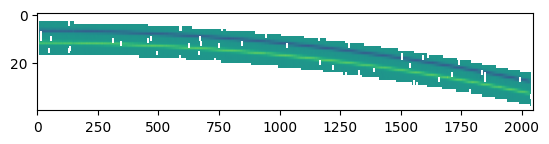

In [14]:
cal1 = datamodels.open(cal_dls['Local Path'][1])
plt.imshow(cal1.slits[10].data, aspect=10)

Looks like it did a subtraction step that might be useful but isn't for our purposes.  So we need to run the pipeline.

In [15]:
asns['Local Path']

./mastDownload/JWST/jw02609-o007_s01035_nirspec_f100lp-g140h/jw02609-o007_20240212t021359_spec3_00001_asn.json
./mastDownload/JWST/jw02609007001_02101_00001_nrs1/jw02609-o007_20240212t021359_image2_00012_asn.json
./mastDownload/JWST/jw02609007001_02101_00001_nrs2/jw02609-o007_20240212t021359_image2_00011_asn.json
./mastDownload/JWST/jw02609007001_02101_00002_nrs1/jw02609-o007_20240212t021359_image2_00010_asn.json
./mastDownload/JWST/jw02609007001_02101_00002_nrs2/jw02609-o007_20240212t021359_image2_00009_asn.json
./mastDownload/JWST/jw02609007001_02101_00004_nrs1/jw02609-o007_20240212t021359_image2_00008_asn.json
./mastDownload/JWST/jw02609007001_02101_00004_nrs2/jw02609-o007_20240212t021359_image2_00007_asn.json
./mastDownload/JWST/jw02609007001_02101_00005_nrs1/jw02609-o007_20240212t021359_image2_00006_asn.json
./mastDownload/JWST/jw02609007001_02101_00005_nrs2/jw02609-o007_20240212t021359_image2_00005_asn.json
./mastDownload/JWST/jw02609007001_02101_00006_nrs1/jw02609-o007_20240212t021359_image2_00004_asn.json
./mastDownload/JWST/jw02609007001_02101_00006_nrs2/jw02609-o007_20240212t021359_image2_00003_asn.json


In [16]:
spec2_asns = asns['Local Path'][np.char.find(asns['Local Path'], 'spec2')!=-1]
spec2_asns = {fn.split('/')[-1]:json.load(open(fn)) for fn in spec2_asns}

Use the data in the association file to download everything needed into a *flat* directory space

In [17]:
flat_dl_root = Path('mastDownload/flat/ ')
flat_dl_root.mkdir(parents=True, exist_ok=True)

In [18]:
to_dl_fns = []
for asn in spec2_asns.values():
    assert len(asn['products']) == 1
    for memb in asn['products'][0]['members']:
        if memb['exptype'] in ('science', 'background'):
            to_dl_fns.append(memb['expname'])
to_dl_fns

['jw02609007001_03101_00002_nrs1_rate.fits',
 'jw02609007001_03101_00003_nrs1_rate.fits',
 'jw02609007001_03101_00002_nrs2_rate.fits',
 'jw02609007001_03101_00003_nrs2_rate.fits',
 'jw02609007001_03101_00003_nrs1_rate.fits',
 'jw02609007001_03101_00002_nrs1_rate.fits',
 'jw02609007001_03101_00003_nrs2_rate.fits',
 'jw02609007001_03101_00002_nrs2_rate.fits']

In [19]:
fn_to_uri = {}
for fn in to_dl_fns:
    matches = ex_prods[ex_prods['productFilename'] == fn]
    assert len(matches)>0,f"no files found with name {fn}!  This shouldn't happen, freaking out"
    assert len(np.unique(matches['dataURI'])) == 1, "two different dataURIs match!  This shouldn't happen, freaking out"
    fn_to_uri[fn] = matches[0]['dataURI']
fn_to_uri

{'jw02609007001_03101_00002_nrs1_rate.fits': 'mast:JWST/product/jw02609007001_03101_00002_nrs1_rate.fits',
 'jw02609007001_03101_00003_nrs1_rate.fits': 'mast:JWST/product/jw02609007001_03101_00003_nrs1_rate.fits',
 'jw02609007001_03101_00002_nrs2_rate.fits': 'mast:JWST/product/jw02609007001_03101_00002_nrs2_rate.fits',
 'jw02609007001_03101_00003_nrs2_rate.fits': 'mast:JWST/product/jw02609007001_03101_00003_nrs2_rate.fits'}

In [20]:
input_paths = []
for nm, uri in fn_to_uri.items():
    res = Observations.download_file(uri, local_path=flat_dl_root / nm)
    if res[0] == 'COMPLETE':
        input_paths.append(flat_dl_root / nm)
    else:
        input_paths.append(None)
        
assert all([pth is not None for pth in input_paths])

input_paths

2024-02-22 19:47:07,300 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_03101_00002_nrs1_rate.fits with expected size 83943360.
2024-02-22 19:47:07,384 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_03101_00003_nrs1_rate.fits with expected size 83943360.
2024-02-22 19:47:07,475 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_03101_00002_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file mastDownload/flat/jw02609007001_03101_00002_nrs1_rate.fits with expected size 83943360. [astroquery.query]
INFO: Found cached file mastDownload/flat/jw02609007001_03101_00003_nrs1_rate.fits with expected size 83943360. [astroquery.query]
INFO: Found cached file mastDownload/flat/jw02609007001_03101_00002_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2024-02-22 19:47:07,566 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_03101_00003_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file mastDownload/flat/jw02609007001_03101_00003_nrs2_rate.fits with expected size 83943360. [astroquery.query]


[PosixPath('mastDownload/flat/jw02609007001_03101_00002_nrs1_rate.fits'),
 PosixPath('mastDownload/flat/jw02609007001_03101_00003_nrs1_rate.fits'),
 PosixPath('mastDownload/flat/jw02609007001_03101_00002_nrs2_rate.fits'),
 PosixPath('mastDownload/flat/jw02609007001_03101_00003_nrs2_rate.fits')]

This might be overkill, but just assume we need all of the MSAs in the matched product set

In [21]:
for row in ex_prods[ex_prods['productSubGroupDescription']=='MSA']:
    Observations.download_file(row['dataURI'], local_path=flat_dl_root / row['productFilename'])

2024-02-22 19:47:07,714 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920.


INFO: Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920. [astroquery.query]


2024-02-22 19:47:07,858 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920.


INFO: Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920. [astroquery.query]


2024-02-22 19:47:07,956 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920.
2024-02-22 19:47:08,030 - stpipe - INFO - Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920.


INFO: Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920. [astroquery.query]
INFO: Found cached file mastDownload/flat/jw02609007001_01_msa.fits with expected size 529920. [astroquery.query]


Now set up the pipleline to run

In [22]:
os.environ.setdefault('CRDS_PATH', '/containerapp/crds_cache')
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

In [23]:
asn_fn = 'jw02609-o007_20240212t021359_spec2_00004_asn.json'
asn = spec2_asns[asn_fn]

redux_path = Path('miscdata/jwst_outputs/redux_test')

redux_path.mkdir(exist_ok=True)

asn = deepcopy(asn)
assert len(asn['products']) == 1

msas = []
prod = asn['products'][0]
for member in prod['members']:
    link = redux_path / member['expname']
    target = flat_dl_root / member['expname']
    if not link.is_symlink():
        link.symlink_to(target.resolve())
    msas.append(fits.getheader(link).get('MSAMETFL', None))

for msa in msas:
    if msa is not None:
        link = redux_path / msa
        target = flat_dl_root / msa
        if not link.is_symlink():
            link.symlink_to(target.resolve())
            
with (redux_path / asn_fn).open('w') as f:
    json.dump(asn, f)

In [24]:
spec2 = Spec2Pipeline()
spec2.save_results = True
spec2.output_dir = str(redux_path)

spec2.srctype.source_type = 'POINT'
spec2.flat_field.save_interpolated_flat = True

spec2.bkg_subtract.skip = False
spec2.resample_spec.skip = True
spec2.extract_1d.skip = True

spec2.assign_wcs.slit_y_high *= 2
spec2.assign_wcs.slit_y_low *= 2

result = spec2(redux_path / asn_fn)

2024-02-22 19:47:08,103 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-02-22 19:47:08,104 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-02-22 19:47:08,105 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-02-22 19:47:08,106 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-02-22 19:47:08,107 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-02-22 19:47:08,108 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-02-22 19:47:08,109 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2024-02-22 19:47:08,111 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2024-02-22 19:47:08,112 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2024-02-22 19:47:08,112 - stpipe.Spec2Pipeline.master_background_mos.pa

In [25]:
ls miscdata/jwst_outputs/redux_test

jw02609-o007_20240212t021359_spec2_00004_asn.json
jw02609007001_01_msa.fits@
jw02609007001_03101_00002_nrs1_cal.fits
jw02609007001_03101_00002_nrs1_interpolatedflat.fits
jw02609007001_03101_00002_nrs1_rate.fits@
jw02609007001_03101_00003_nrs1_rate.fits@


In [39]:
len(result[0].slits)

44

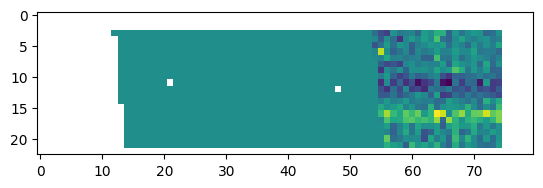

In [42]:
plt.imshow(result[0].slits[0].data)

Alright, this is all good.  Just need to put it in template form now.

# Try target-level from the program

In [63]:
all_prods = Observations.get_product_list(obses)
all_prods

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str70,str9,str28,str11,str1,str7,str6,str4,str52,int64,str9,str16,int64
89383635,JWST,image,jw02609-o001_t006_nircam_clear-f150w,target (L3) : segmentation map,D,mast:JWST/product/jw02609-o001_t006_nircam_clear-f150w_segm.fits,AUXILIARY,Minimum Recommended Products,SEGM,--,CALJWST,1.12.5,2609,jw02609-o001_t006_nircam_clear-f150w_segm.fits,424235520,89383635,PUBLIC,3
89383635,JWST,image,jw02609-o001_t006_nircam_clear-f150w,source/target (L3) : association generator,D,mast:JWST/product/jw02609-o001_20240212t021359_image3_00002_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.12.5,2609,jw02609-o001_20240212t021359_image3_00002_asn.json,8671,89383635,PUBLIC,3
89383635,JWST,image,jw02609-o001_t006_nircam_clear-f150w,source/target (L3) : association pool,D,mast:JWST/product/jw02609_20240212t021359_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.12.5,2609,jw02609_20240212t021359_pool.csv,76723,89383635,PUBLIC,3
89383635,JWST,image,jw02609-o001_t006_nircam_clear-f150w,Preview-Full,D,mast:JWST/product/jw02609-o001_t006_nircam_clear-f150w_i2d.jpg,PREVIEW,--,--,--,CALJWST,1.12.5,2609,jw02609-o001_t006_nircam_clear-f150w_i2d.jpg,26592488,89383635,PUBLIC,3
89383635,JWST,image,jw02609-o001_t006_nircam_clear-f150w,target (L3) : source catalog,D,mast:JWST/product/jw02609-o001_t006_nircam_clear-f150w_cat.ecsv,SCIENCE,Minimum Recommended Products,CAT,--,CALJWST,1.12.5,2609,jw02609-o001_t006_nircam_clear-f150w_cat.ecsv,56937997,89383635,PUBLIC,3
89383635,JWST,image,jw02609-o001_t006_nircam_clear-f150w,exposure/target (L2b/L3): rectified 2D image,D,mast:JWST/product/jw02609-o001_t006_nircam_clear-f150w_i2d.fits,SCIENCE,Minimum Recommended Products,I2D,--,CALJWST,1.12.5,2609,jw02609-o001_t006_nircam_clear-f150w_i2d.fits,2969553600,89383635,PUBLIC,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108153644,JWST,image,jw02609011002_02101_00004_nrcblong,Preview-Full,S,mast:JWST/product/jw02609011002_02101_00004_nrcblong_trapsfilled.jpg,PREVIEW,--,--,--,CALJWST,1.12.5,2609,jw02609011002_02101_00004_nrcblong_trapsfilled.jpg,49533,108153699,PUBLIC,2
108153644,JWST,image,jw02609011002_02101_00004_nrcblong,exposure (L2c): 2D Calibrated data averaged over integrations,S,mast:JWST/product/jw02609011002_02101_00004_nrcblong_o011_crf.fits,SCIENCE,--,ANNNN_CRF,--,CALJWST,1.12.5,2609,jw02609011002_02101_00004_nrcblong_o011_crf.fits,117541440,108153699,PUBLIC,2


In [66]:
all_msas = all_prods[all_prods['productSubGroupDescription']=='MSA']
all_msas

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str9,str4,str8,str40,str71,str1,str70,str9,str28,str11,str1,str7,str6,str4,str52,int64,str9,str16,int64
98739647,JWST,image,jw02609006001_03101_00002_nrs1,MSA metadata,S,mast:JWST/product/jw02609006001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609006001_01_msa.fits,532800,127980833,PUBLIC,1
98739647,JWST,image,jw02609006001_03101_00002_nrs1,MSA metadata,S,mast:JWST/product/jw02609006001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609006001_01_msa.fits,532800,127980862,PUBLIC,1
98739647,JWST,image,jw02609006001_03101_00002_nrs1,MSA metadata,S,mast:JWST/product/jw02609006001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609006001_01_msa.fits,532800,127980891,PUBLIC,1
98739647,JWST,image,jw02609006001_03101_00002_nrs1,MSA metadata,S,mast:JWST/product/jw02609006001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609006001_01_msa.fits,532800,127980927,PUBLIC,1
98739647,JWST,image,jw02609006001_03101_00002_nrs1,MSA metadata,S,mast:JWST/product/jw02609006001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609006001_01_msa.fits,532800,127980957,PUBLIC,1
98739647,JWST,image,jw02609006001_03101_00002_nrs1,MSA metadata,S,mast:JWST/product/jw02609006001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609006001_01_msa.fits,532800,127980995,PUBLIC,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150909879,JWST,image,jw02609010001_03101_00002_nrs2,MSA metadata,S,mast:JWST/product/jw02609010001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609010001_01_msa.fits,532800,150936686,EXCLUSIVE_ACCESS,1
150909879,JWST,image,jw02609010001_03101_00002_nrs2,MSA metadata,S,mast:JWST/product/jw02609010001_01_msa.fits,AUXILIARY,--,MSA,--,CALJWST,--,2609,jw02609010001_01_msa.fits,532800,150936695,EXCLUSIVE_ACCESS,1


In [76]:
len(np.unique(all_msas['productFilename'])), len(np.unique(all_msas['obsID']))

(9, 24)

2040 condense to... 9 🤷

In [86]:
already = set()
msk = []
for row in all_msas:
    key = row['productFilename']
    if key not in already:
        msk.append(True)
        already.add(key)
    else:
        msk.append(False)
msk = np.array(msk)

all_msas_dl = Observations.download_products(all_msas[msk])

INFO: Found cached file ./mastDownload/JWST/jw02609006001_03101_00002_nrs1/jw02609006001_01_msa.fits with expected size 532800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609007001_03101_00002_nrs1/jw02609007001_01_msa.fits with expected size 529920. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609009001_04101_00001_nrs1/jw02609009001_01_msa.fits with expected size 547200. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609009001_04103_00001_nrs1/jw02609009001_02_msa.fits with expected size 547200. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609009001_04105_00001_nrs1/jw02609009001_03_msa.fits with expected size 547200. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609009001_04107_00001_nrs1/jw02609009001_04_msa.fits with expected size 547200. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02609009001_04109_00001_nrs1/jw02609009001_05_msa.fits with expected siz

In [93]:
msa_shutter_infos = {pth.split('/')[-1]: table.Table.read(pth, hdu='SHUTTER_INFO') for pth in all_msas_dl['Local Path']}
msa_source_infos = {pth.split('/')[-1]: table.Table.read(pth, hdu='SOURCE_INFO') for pth in all_msas_dl['Local Path']}

In [96]:
msa_source_infos['jw02609006001_01_msa.fits']

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,bytes20,bytes31,float64,float64,bytes30,float64
2609,3,2609_3,3,298.457514919769,18.7497862580305,None,1.0
2609,7,2609_7,7,298.43853829457,18.7820519414859,None,1.0
2609,9,2609_9,9,298.44794595758,18.7713820491861,None,1.0
2609,11,2609_11,11,298.468179889577,18.7483742358947,None,1.0
2609,12,2609_12,12,298.41610677197,18.7313767580844,None,1.0
2609,19,2609_19,19,298.437395725539,18.7292034769328,None,1.0
...,...,...,...,...,...,...,...
2609,4455,2609_4455,4455,298.44531364653,18.7310029442722,None,1.0
2609,4500,2609_4500,4500,298.4384018987591,18.7278992263709,None,1.0


In [97]:
msa_shutter_infos['jw02609006001_01_msa.fits']

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,bytes1,bytes6,float32,float32,int16,bytes1
2,1,2,55,74,1781,N,OPEN,0.471,0.871,1,Y
2,1,2,55,74,1781,Y,OPEN,--,--,2,N
2,1,2,55,75,1781,Y,OPEN,--,--,1,N
2,1,2,55,75,1781,N,OPEN,0.459,0.88,2,Y
3,1,2,81,80,54,N,OPEN,0.211,0.168,1,Y
3,1,2,81,80,54,Y,OPEN,--,--,2,N
...,...,...,...,...,...,...,...,...,...,...,...
74,1,3,342,27,3127,Y,OPEN,--,--,2,N
74,1,3,342,28,3127,Y,OPEN,--,--,1,N


Hmm, turns out there's no straightforward way to connect these back to the relevant cal/etc files. Implies the other approach is better.